<a href="https://colab.research.google.com/github/vkthakur90/AI_Applications/blob/master/Positional_Trading_with_Auto_Regression_Finite_Horizon_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import seaborn as sns
from datetime import datetime, timedelta

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
ticker = 'BANKBEES.NS'
prev_day = 0
scale_factor = 1.0e2

ar_p = 250
ar_h = 100

num_paths = 1000
paths_to_plot = 5

risk_budget = 100

In [4]:
def download_data(entity):
    print(f"Downloading {ticker}")

    # Download intraday data with a 1-minute interval.
    data = yf.download(ticker, period="5y", interval="1d")

    if data.index.tzinfo is None:
        data.index = data.index.tz_localize('UTC')

    data.index = data.index.tz_convert('Asia/Kolkata')

    data_ = pd.DataFrame({
        'S' : data['Close'].values.reshape((-1,))
    }, index = data.index)

    entity['data'] = data_

In [5]:
def calculate_return(entity):
    data = entity['data']

    data.eval('log_S = log(S)', inplace = True)
    data['r'] = scale_factor * data['log_S'].diff()

In [6]:
def split_data(entity):
    entity['train'] = entity['data'].iloc[:-ar_h]
    entity['test'] = entity['data'].iloc[-ar_h:]

In [7]:
def feature_engg(entity):
    data = entity['train']

    features_df = data[['S', 'r']]

    for idx in range(ar_p):
        features_df[f'r_m{idx + 1}'] = features_df['r'].shift(idx + 1)

    for idx in range(ar_h):
        features_df[f'r_p{idx}'] = features_df['r'].shift(-idx)


    features_df.dropna(inplace = True)

    entity['features'] = features_df

In [8]:
def fit_ar_model(entity):
    formula_list = [f'r_p{idx} ~ ' + ' + '.join([f'r_m{idx + 1}' for idx in range(ar_p)]) for idx in range(ar_h)]

    entity['ar_models'] = [smf.ols(formula, data = entity['features']).fit() for formula in formula_list]

    entity['ar_params'] = pd.DataFrame({m.model.endog_names : m.params for m in entity['ar_models']})
    entity['ar_residue'] = pd.DataFrame({m.model.endog_names : m.resid for m in entity['ar_models']})

    temp = entity['ar_params'].T

    temp['sigma'] = ((entity['ar_residue']**2).sum()/(len(entity['ar_residue']) - ar_p - 1)).apply(np.sqrt)

    entity['ar_params'] = temp.T

    entity['ar_weights'] =  entity['ar_params'].iloc[1:-1]
    entity['ar_bias'] =  entity['ar_params'].iloc[0]
    entity['ar_sigma'] =  entity['ar_params'].iloc[-1]


In [9]:
def test_forecast_return(entity):
    forecast_features_df = pd.DataFrame(
        data = np.stack([entity['train']['r'].iloc[-ar_p:].values]*num_paths),
        columns = [f'r_m{idx + 1}' for idx in range(ar_p)],
        index = [f'paths_{idx + 1}' for idx in range(num_paths)]
    )

    random_numbers_df = pd.DataFrame(
        data = np.random.standard_normal(size = (num_paths, ar_h)),
        columns = entity['ar_weights'].columns,
        index = forecast_features_df.index
    )

    entity['test_forecast'] = np.matmul(forecast_features_df, entity['ar_weights']) + entity['ar_bias'] + entity['ar_sigma'] * random_numbers_df
    entity['test_forecast'] = entity['test_forecast'].T
    entity['test_forecast'].index = entity['test'].index

    prev_S = entity['train'].iloc[-1]['S']

    entity['test_forecast_price'] = prev_S * entity['test_forecast'].cumsum().apply(lambda t : np.exp(t/scale_factor))

    entity['test_monte_carlo_quantiles'] = entity['test_forecast_price'].quantile([0.025, 0.25, 0.50, 0.75, .975], axis = 1).T
    entity['test_monte_carlo_quantiles'].columns = ['low_ci', 'quart_1st', 'median', 'quart_3rd', 'high_ci']

In [10]:
def forecast_return(entity):
    forecast_features_df = pd.DataFrame(
        data = np.stack([entity['data']['r'].iloc[-ar_p:].values]*num_paths),
        columns = [f'r_m{idx + 1}' for idx in range(ar_p)],
        index = [f'paths_{idx + 1}' for idx in range(num_paths)]
    )

    random_numbers_df = pd.DataFrame(
        data = np.random.standard_normal(size = (num_paths, ar_h)),
        columns = entity['ar_weights'].columns,
        index = forecast_features_df.index
    )

    entity['forecast'] = np.matmul(forecast_features_df, entity['ar_weights']) + entity['ar_bias'] + entity['ar_sigma'] * random_numbers_df
    entity['forecast'] = entity['forecast'].T
    entity['forecast'].index = np.arange(ar_h)


    prev_S = entity['data'].iloc[-1]['S']

    entity['forecast_price'] = prev_S * entity['forecast'].cumsum().apply(lambda t : np.exp(t/scale_factor))

    entity['monte_carlo_quantiles'] = entity['forecast_price'].quantile([0.025, 0.25, 0.50, 0.75, .975], axis = 1).T
    entity['monte_carlo_quantiles'].columns = ['low_ci', 'quart_1st', 'median', 'quart_3rd', 'high_ci']

In [11]:
entity = {}
download_data(entity)
calculate_return(entity)
split_data(entity)
feature_engg(entity)
fit_ar_model(entity)
test_forecast_return(entity)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [12]:
forecast_return(entity)

In [13]:
selected_paths = np.random.choice(entity['test_forecast'].columns, paths_to_plot, replace=False)

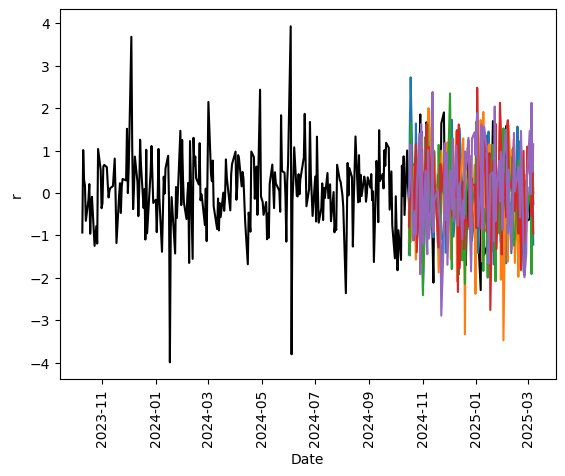

In [14]:
sns.lineplot(x = 'Date', y = 'r', data = entity['data'].iloc[-350:].reset_index(), color = 'black')

for p in selected_paths:
    sns.lineplot(x = 'Date', y = p, data = entity['test_forecast'].reset_index())

_ = plt.xticks(rotation=90)

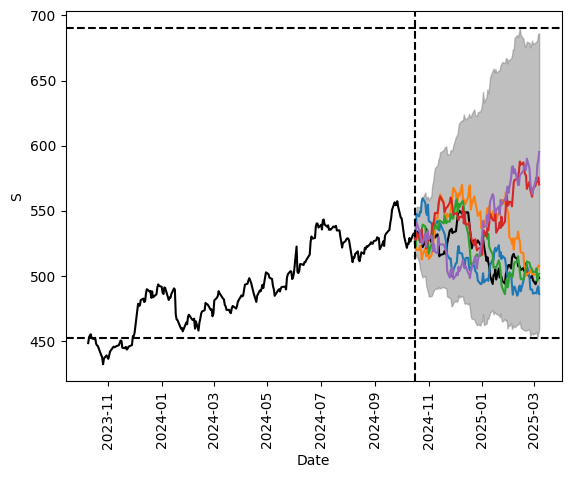

In [15]:
sns.lineplot(x = 'Date', y = 'S', data = entity['data'].iloc[-350:].reset_index(), color = 'black')

for p in selected_paths:
    sns.lineplot(x = 'Date', y = p, data = entity['test_forecast_price'].reset_index())

plt.fill_between(entity['test_monte_carlo_quantiles'].index, entity['test_monte_carlo_quantiles']['low_ci'], entity['test_monte_carlo_quantiles']['high_ci'], color = 'grey', alpha = 0.5)
plt.axhline(entity['test_monte_carlo_quantiles']['low_ci'].min(), linestyle = '--', color = 'black')
plt.axhline(entity['test_monte_carlo_quantiles']['high_ci'].max(), linestyle = '--', color = 'black')
plt.axvline(entity['test_monte_carlo_quantiles'].index[0], linestyle = '--', color = 'black')
_ = plt.xticks(rotation=90)

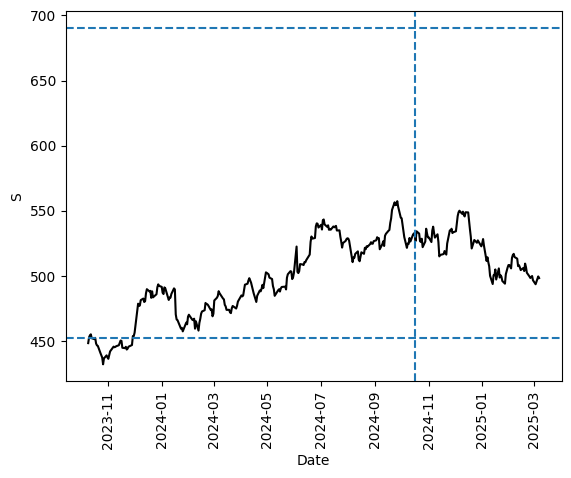

In [16]:
sns.lineplot(x = 'Date', y = 'S', data = entity['data'].iloc[-350:].reset_index(), color = 'black')
plt.axhline(entity['test_monte_carlo_quantiles']['low_ci'].min(), linestyle = '--')
plt.axhline(entity['test_monte_carlo_quantiles']['high_ci'].max(), linestyle = '--')
plt.axvline(entity['test_monte_carlo_quantiles'].index[0], linestyle = '--')
_ = plt.xticks(rotation=90)

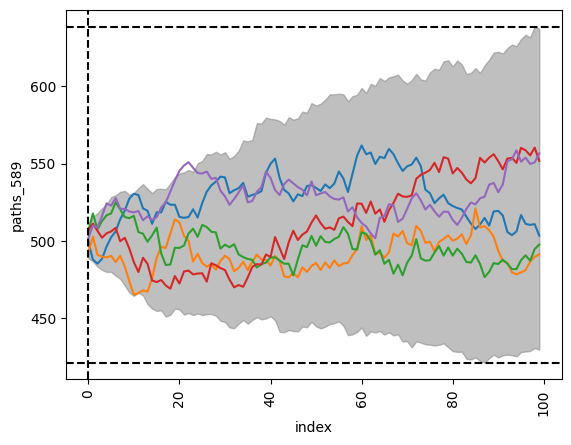

In [17]:
selected_paths = np.random.choice(entity['forecast'].columns, paths_to_plot, replace=False)

for p in selected_paths:
    sns.lineplot(x = 'index', y = p, data = entity['forecast_price'].reset_index())

plt.fill_between(entity['monte_carlo_quantiles'].index, entity['monte_carlo_quantiles']['low_ci'], entity['monte_carlo_quantiles']['high_ci'], color = 'grey', alpha = 0.5)
plt.axhline(entity['monte_carlo_quantiles']['low_ci'].min(), linestyle = '--', color = 'black')
plt.axhline(entity['monte_carlo_quantiles']['high_ci'].max(), linestyle = '--', color = 'black')
plt.axvline(entity['monte_carlo_quantiles'].index[0], linestyle = '--', color = 'black')
_ = plt.xticks(rotation=90)

In [19]:
entity['monte_carlo_quantiles']['low_ci'].min()

421.3232401343745

In [20]:
entity['monte_carlo_quantiles']['high_ci'].max()

638.5741947428029